# Reddit Wall Street Bets Sentiment Analysis

<img src="../images/reddit.jpg">

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
import plotly.express as px
import datetime as dt

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from matplotlib.pyplot import figure
from datetime import datetime
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Data Cleaning

In [61]:
df = pd.read_csv('../reddit_wsb.csv')

In [62]:
df_gme = pd.read_csv('../gme.csv')

In [63]:
# Drop unnecessary columns for analysis
df = df.drop(columns=['id', 'url', 'created', 'Unnamed: 10', 'Dates'])

In [64]:
df_gme = df_gme.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Change'])

In [65]:
# Handle missing values
df.isnull().sum()
df = df.dropna(subset=['timestamp', 'change (+/-)'])

In [66]:
df_gme.isnull().sum()
df_gme = df_gme.dropna()

In [67]:
# Information about dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37149 entries, 0 to 37148
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         37149 non-null  object 
 1   score         37149 non-null  object 
 2   comms_num     37149 non-null  object 
 3   body          17583 non-null  object 
 4   timestamp     37149 non-null  object 
 5   change (+/-)  37149 non-null  float64
dtypes: float64(1), object(5)
memory usage: 2.0+ MB


In [68]:
df_gme.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 62
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          63 non-null     object 
 1   Adj Close     63 non-null     float64
 2   Change (+/-)  63 non-null     float64
dtypes: float64(2), object(1)
memory usage: 2.0+ KB


In [69]:
# Describe dataset
df.describe()

,change (+/-)
count,37149.000000
mean,0.744946
std,0.435897
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [70]:
df_gme.describe()

,Adj Close,Change (+/-)
count,63.000000,63.000000
mean,148.368889,0.444444
std,66.189996,0.500895
min,40.590000,0.000000
25%,97.075001,0.000000
50%,158.509995,0.000000
75%,190.635002,1.000000
max,325.000000,1.000000


In [71]:
df.head(10)

,title,score,comms_num,body,timestamp,change (+/-)
0,An autists journey. $150 to $68k in one month....,50,8,NaN,1/28/2021 9:08,1.0
1,You all have made Melvin live up to its name,70,7,NaN,1/28/2021 9:08,1.0
2,I got in late on GME but I believe in the caus...,75,14,You guys are amazing. Thank you for sending GM...,1/28/2021 9:08,1.0
3,Highest SI % of Float End of Business Jan 27th...,26,22,Will Update Daily At Market Close\n\nTop 5 sec...,1/28/2021 9:08,1.0
4,Discord still down,0,6,i can't see how to talk to to any anti bot mea...,1/28/2021 9:08,1.0
5,What are you doing to AMC?,67,55,Hey retards what the hell is going on with AMC...,1/28/2021 9:08,1.0
6,HOW CAN I BUY STOCK????!!!,0,12,I'm from canada and want to know the best trad...,1/28/2021 9:08,1.0
7,"Buy games at GameStop, donate to charity (not ...",50,9,"Value goes up, kids play video games",1/28/2021 9:08,1.0
8,How do i invest in GameStop? I don't know anyt...,0,21,NaN,1/28/2021 9:08,1.0
9,Hmmmmmm turns out BlackRock is making use of o...,66,8,NaN,1/28/2021 9:08,1.0


In [72]:
df_gme.head(10)

,Date,Adj Close,Change (+/-)
0,1/28/2021,193.600006,1.0
1,1/29/2021,325.000000,1.0
2,2/1/2021,225.000000,0.0
3,2/2/2021,90.000000,0.0
4,2/3/2021,92.410004,1.0
5,2/4/2021,53.500000,0.0
6,2/5/2021,63.770000,1.0
7,2/8/2021,60.000000,0.0
8,2/9/2021,50.310001,0.0
9,2/10/2021,51.200001,1.0


### Text Preprocessing

In [73]:
nltk.download('punkt')
porter = nltk.PorterStemmer()

[nltk_data] Downloading package punkt to C:\Users\Abhi
[nltk_data]     Joshi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
def text_preprocessing(text): 
    # tokenization, remove punctuation, lemmatization
    words = word_tokenize(str(text))
    words = RegexpTokenizer(r'\w+')
    words = [porter.stem(t) for t in str(text).split()]
    
    # remove symbols, websites, email addresses 
    words = [re.sub(r"[^A-Za-z@]", "", word) for word in words] 
    words = [re.sub(r"\S+com", "", word) for word in words]
    words = [re.sub(r"\S+@\S+", "", word) for word in words] 
    words = [word for word in words if word != " " and word != ""]
    words = [word for word in words if len(word) != 0] 
    
    # remove stopwords     
    stopwords = set(STOPWORDS)
    stopwords.update(nltk.corpus.stopwords.words('english'))
    stopwords_lower = [s.lower() for s in stopwords]
    words=[word.lower() for word in words if word.lower() not in stopwords_lower]
    
    # combine a list into one string   
    string = " ".join(words)
    
    return string

In [75]:
df['title_cleaned'] = df['title'].apply(text_preprocessing)
df['body_cleaned'] = df['body'].apply(text_preprocessing)
df['combined_cleaned'] = df['title_cleaned'] + ' ' + df['body_cleaned']

In [76]:
df.head(10)

,title,score,comms_num,body,timestamp,change (+/-),title_cleaned,body_cleaned,combined_cleaned
0,An autists journey. $150 to $68k in one month....,50,8,NaN,1/28/2021 9:08,1.0,autist journey one month storytim,nan,autist journey one month storytim nan
1,You all have made Melvin live up to its name,70,7,NaN,1/28/2021 9:08,1.0,made melvin live name,nan,made melvin live name nan
2,I got in late on GME but I believe in the caus...,75,14,You guys are amazing. Thank you for sending GM...,1/28/2021 9:08,1.0,got late gme believ caus lose,guy amazing thank send gme moon know im go los...,got late gme believ caus lose guy amazing than...
3,Highest SI % of Float End of Business Jan 27th...,26,22,Will Update Daily At Market Close\n\nTop 5 sec...,1/28/2021 9:08,1.0,highest si float end busi jan th accord partner,updat daili market close top secur si float en...,highest si float end busi jan th accord partne...
4,Discord still down,0,6,i can't see how to talk to to any anti bot mea...,1/28/2021 9:08,1.0,discord still,cant see talk ani anti bot measure ani admin c...,discord still cant see talk ani anti bot measu...
5,What are you doing to AMC?,67,55,Hey retards what the hell is going on with AMC...,1/28/2021 9:08,1.0,amc,hey retard hell go amc hours tri give prematur...,amc hey retard hell go amc hours tri give prem...
6,HOW CAN I BUY STOCK????!!!,0,12,I'm from canada and want to know the best trad...,1/28/2021 9:08,1.0,buy stock,im canada want know best trade platform use bu...,buy stock im canada want know best trade platf...
7,"Buy games at GameStop, donate to charity (not ...",50,9,"Value goes up, kids play video games",1/28/2021 9:08,1.0,buy game gamestop donat chariti goodwill,valu goe kid play video game,buy game gamestop donat chariti goodwill valu ...
8,How do i invest in GameStop? I don't know anyt...,0,21,NaN,1/28/2021 9:08,1.0,invest gamestop dont know anyth stock markets,nan,invest gamestop dont know anyth stock markets nan
9,Hmmmmmm turns out BlackRock is making use of o...,66,8,NaN,1/28/2021 9:08,1.0,hmmmmmm turn blackrock make use weapon autism,nan,hmmmmmm turn blackrock make use weapon autism nan


### Data Visualization

In [77]:
# Extract titles and bodies of the wsbets posts
vis_df = df[['title', 'body', 'timestamp']].copy()
vis_df.head(10)

,title,body,timestamp
0,An autists journey. $150 to $68k in one month....,NaN,1/28/2021 9:08
1,You all have made Melvin live up to its name,NaN,1/28/2021 9:08
2,I got in late on GME but I believe in the caus...,You guys are amazing. Thank you for sending GM...,1/28/2021 9:08
3,Highest SI % of Float End of Business Jan 27th...,Will Update Daily At Market Close\n\nTop 5 sec...,1/28/2021 9:08
4,Discord still down,i can't see how to talk to to any anti bot mea...,1/28/2021 9:08
5,What are you doing to AMC?,Hey retards what the hell is going on with AMC...,1/28/2021 9:08
6,HOW CAN I BUY STOCK????!!!,I'm from canada and want to know the best trad...,1/28/2021 9:08
7,"Buy games at GameStop, donate to charity (not ...","Value goes up, kids play video games",1/28/2021 9:08
8,How do i invest in GameStop? I don't know anyt...,NaN,1/28/2021 9:08
9,Hmmmmmm turns out BlackRock is making use of o...,NaN,1/28/2021 9:08


In [78]:
# Combine into plain text column
vis_df = vis_df.dropna()
vis_df['combined'] = vis_df['title'] + ' ' + vis_df['body']
vis_df = vis_df.reset_index()

In [79]:
vis_df.head(10)

,index,title,body,timestamp,combined
0,2,I got in late on GME but I believe in the caus...,You guys are amazing. Thank you for sending GM...,1/28/2021 9:08,I got in late on GME but I believe in the caus...
1,3,Highest SI % of Float End of Business Jan 27th...,Will Update Daily At Market Close\n\nTop 5 sec...,1/28/2021 9:08,Highest SI % of Float End of Business Jan 27th...
2,4,Discord still down,i can't see how to talk to to any anti bot mea...,1/28/2021 9:08,Discord still down i can't see how to talk to ...
3,5,What are you doing to AMC?,Hey retards what the hell is going on with AMC...,1/28/2021 9:08,What are you doing to AMC? Hey retards what th...
4,6,HOW CAN I BUY STOCK????!!!,I'm from canada and want to know the best trad...,1/28/2021 9:08,HOW CAN I BUY STOCK????!!! I'm from canada and...
5,7,"Buy games at GameStop, donate to charity (not ...","Value goes up, kids play video games",1/28/2021 9:08,"Buy games at GameStop, donate to charity (not ..."
6,12,Can we become a force for good with our power?,"Hey Gang,\n\nLong time user that recently got ...",1/28/2021 9:08,Can we become a force for good with our power?...
7,13,Did I just get fucked investing into NAKD,Did I fall for a pump and dump is my money gon...,1/28/2021 9:09,Did I just get fucked investing into NAKD Did ...
8,17,Is it too late to buy Gamestop shares?,I’ve been really busy this week and haven’t be...,1/28/2021 9:09,Is it too late to buy Gamestop shares? I’ve be...
9,18,Pending transfer RH question,Will upgrading to RH Gold make my current pend...,1/28/2021 9:09,Pending transfer RH question Will upgrading to...


In [80]:
# Now let's run the same analysis for all posts
text = ' '.join(vis_df.combined)
print ("There are {} words in the combination of all posts and titles on r/wsbets.".format(len(text)))

There are 18668752 words in the combination of all posts and titles on r/wsbets.


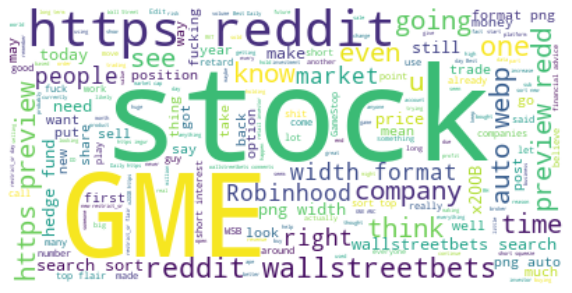

In [81]:
# Create stopword list
stopwords = set(STOPWORDS)
stopwords.update(nltk.corpus.stopwords.words('english'))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Display the generated image
plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### GME Sentiment Analysis

In [83]:
# Helper function to get only GME posts
def getGME(text):
    return "gme" in text.lower() or 'game stop' in text.lower() or 'gamestop' in text.lower()

In [84]:
# Filter dataframe based on posts with GME in them
gme_sent_df = df[['timestamp', 'combined_cleaned', 'change (+/-)']].copy()
gme_sent_df['containsGME'] = df['combined_cleaned'].apply(getGME)
gme_sent_df.drop(gme_sent_df[gme_sent_df['containsGME'] == False].index, inplace = True)

In [85]:
# Clean GME posts dataset
gme_sent_df = gme_sent_df.drop(columns=['containsGME'])
gme_sent_df = gme_sent_df.reset_index()

In [86]:
gme_sent_df.head(10)

,index,timestamp,combined_cleaned,change (+/-)
0,2,1/28/2021 9:08,got late gme believ caus lose guy amazing than...,1.0
1,3,1/28/2021 9:08,highest si float end busi jan th accord partne...,1.0
2,7,1/28/2021 9:08,buy game gamestop donat chariti goodwill valu ...,1.0
3,8,1/28/2021 9:08,invest gamestop dont know anyth stock markets nan,1.0
4,10,1/28/2021 9:08,im argentina read game stop story must say guy...,1.0
5,11,1/28/2021 9:08,gme reinforc way nan,1.0
6,12,1/28/2021 9:08,forc good power hey gang long time user recent...,1.0
7,14,1/28/2021 9:09,gain porn gme nok bb nan,1.0
8,17,1/28/2021 9:09,late buy gamestop shares iv realli busi thi we...,1.0
9,18,1/28/2021 9:09,pend transfer rh question upgrad rh gold make ...,1.0


In [87]:
# Train and test split
X_train, X_test, y_train, y_test = train_test_split(gme_sent_df['combined_cleaned'], 
                                                    gme_sent_df['change (+/-)'], 
                                                    random_state=0)

# Build a machine learning pipeline
est = Pipeline([('vectorizer', TfidfVectorizer(lowercase=False)),
 ('classifier', LogisticRegression(max_iter=1000))])

# GridSearchCV with a transformer and a estimator
parameters = {'vectorizer__max_df': (0.8,0.9), 
 'vectorizer__min_df': [20,50,0.1],
 "classifier__C": np.logspace(-3,3,7)}
gs = GridSearchCV(est, param_grid=parameters)
gs.fit(X_train, y_train)

model = LogisticRegression(C=gs.best_params_['classifier__C'], max_iter=1000)
vect = TfidfVectorizer(min_df=gs.best_params_['vectorizer__min_df'],max_df=gs.best_params_['vectorizer__max_df']).fit(X_train)

# Fit the training data
model.fit(vect.transform(X_train), y_train)

# Evaluate the model
predictions = model.predict(vect.transform(X_test))
print('AUC: ', roc_auc_score(y_test, predictions))

AUC:  0.5699706156961494


In [88]:
# Find out the words that contributes to price increase or decrease
feature_names = np.array(vect.get_feature_names())

# Sort the coefficients from the model
sorted_coef_index = model.coef_[0].argsort()

# Find the 10 smallest and 10 largest coefficients
print('Smallest Coefs:\n{}'.format(feature_names[sorted_coef_index[:10]]))
print('Largest Coefs: \n{}'.format(feature_names[sorted_coef_index[:-11:-1]]))

Smallest Coefs:
['nan' 'silver' 'hedgi' 'articl' 'fud' 'ape' 'edit' 'roll' 'week' 'hear']
Largest Coefs: 
['buy' 'robinhood' 'webul' 'block' 'app' 'shut' 'rkt' 'broker' 'allow'
 'fuck']


### Tracking GME Sentiment Over Time

In [89]:
# Create functions to get subjectivity and polarity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

In [90]:
# Get subjectivity and polarity of GME posts
gme_sent_df['Subjectivity'] = gme_sent_df['combined_cleaned'].apply(getSubjectivity)
gme_sent_df['Polarity'] = gme_sent_df['combined_cleaned'].apply(getPolarity)

In [91]:
gme_sent_df.head(10)

,index,timestamp,combined_cleaned,change (+/-),Subjectivity,Polarity
0,2,1/28/2021 9:08,got late gme believ caus lose guy amazing than...,1.0,0.720833,-0.025000
1,3,1/28/2021 9:08,highest si float end busi jan th accord partne...,1.0,0.500000,0.500000
2,7,1/28/2021 9:08,buy game gamestop donat chariti goodwill valu ...,1.0,0.400000,-0.400000
3,8,1/28/2021 9:08,invest gamestop dont know anyth stock markets nan,1.0,0.000000,0.000000
4,10,1/28/2021 9:08,im argentina read game stop story must say guy...,1.0,0.700000,0.300000
5,11,1/28/2021 9:08,gme reinforc way nan,1.0,0.000000,0.000000
6,12,1/28/2021 9:08,forc good power hey gang long time user recent...,1.0,0.545833,0.329167
7,14,1/28/2021 9:09,gain porn gme nok bb nan,1.0,0.000000,0.000000
8,17,1/28/2021 9:09,late buy gamestop shares iv realli busi thi we...,1.0,0.600000,-0.325000
9,18,1/28/2021 9:09,pend transfer rh question upgrad rh gold make ...,1.0,0.533333,0.000000


In [92]:
# Function to get the sentiment for each post
def getSIA(text):
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

In [93]:
# Get sentiment scores for each post
compound = []
neg = []
pos = []
sent = []
sent_value = []
for i in range(0, len(gme_sent_df['combined_cleaned'])):
    SIA = getSIA(gme_sent_df['combined_cleaned'][i])
    compound.append(SIA['compound'])
    neg.append(SIA['neg'])
    pos.append(SIA['pos'])
    max_value = max(SIA['neg'], SIA['pos'])
    sent_value.append(max_value)
    if max_value == SIA['neg']:
        sent.append('negative')
    else:
        sent.append('positive')
# Store sentiments inside dataframe
gme_sent_df['Compound'] = compound
gme_sent_df['Positive'] = pos
gme_sent_df['Negative'] = neg
gme_sent_df['Sentiment'] = sent
gme_sent_df['Sentiment Value'] = sent_value

In [94]:
gme_sent_df.head(10)

,index,timestamp,combined_cleaned,change (+/-),Subjectivity,Polarity,Compound,Positive,Negative,Sentiment,Sentiment Value
0,2,1/28/2021 9:08,got late gme believ caus lose guy amazing than...,1.0,0.720833,-0.025000,0.1779,0.178,0.164,positive,0.178
1,3,1/28/2021 9:08,highest si float end busi jan th accord partne...,1.0,0.500000,0.500000,0.2023,0.045,0.000,positive,0.045
2,7,1/28/2021 9:08,buy game gamestop donat chariti goodwill valu ...,1.0,0.400000,-0.400000,0.3400,0.179,0.000,positive,0.179
3,8,1/28/2021 9:08,invest gamestop dont know anyth stock markets nan,1.0,0.000000,0.000000,0.0000,0.000,0.000,negative,0.000
4,10,1/28/2021 9:08,im argentina read game stop story must say guy...,1.0,0.700000,0.300000,0.4404,0.268,0.144,positive,0.268
5,11,1/28/2021 9:08,gme reinforc way nan,1.0,0.000000,0.000000,0.0000,0.000,0.000,negative,0.000
6,12,1/28/2021 9:08,forc good power hey gang long time user recent...,1.0,0.545833,0.329167,0.9816,0.306,0.033,positive,0.306
7,14,1/28/2021 9:09,gain porn gme nok bb nan,1.0,0.000000,0.000000,0.5267,0.405,0.000,positive,0.405
8,17,1/28/2021 9:09,late buy gamestop shares iv realli busi thi we...,1.0,0.600000,-0.325000,-0.0258,0.147,0.117,positive,0.147
9,18,1/28/2021 9:09,pend transfer rh question upgrad rh gold make ...,1.0,0.533333,0.000000,0.0000,0.000,0.000,negative,0.000


In [144]:
# Plot GME Positive vs Negative Sentiment Counts over Time
base = dt.datetime.strptime(gme_sent_df.iloc[0].timestamp, '%m/%d/%Y %H:%M').date()
end = dt.datetime.strptime(gme_sent_df.iloc[gme_sent_df.shape[0] - 1].timestamp, '%m/%d/%Y %H:%M').date()
numdays = (end - base).days
dates_keys = [base + dt.timedelta(days=x) for x in range(numdays + 1)]
dates_vals = [0] * len(dates_keys)
dates_dict_pos = {k:v for k,v in zip(dates_keys, dates_vals)}
dates_dict_neg = {k:v for k,v in zip(dates_keys, dates_vals)}
for i in range(gme_sent_df.shape[0]):
    curr_date = dt.datetime.strptime(gme_sent_df.iloc[i].timestamp, '%m/%d/%Y %H:%M').date()
    if curr_date in dates_dict:
        if gme_sent_df.iloc[i].Positive >= gme_sent_df.iloc[i].Negative:
            dates_dict_pos[curr_date] += 1
        else:
            dates_dict_neg[curr_date] += 1
            
# Clean all unnecessary dates with no posts
for key, val in list(dates_dict_pos.items()):
    if val == 0:
        del dates_dict_pos[key]

for key, val in list(dates_dict_neg.items()):
    if val == 0:
        del dates_dict_neg[key]

df_counts = pd.DataFrame(list(dates_dict_pos.items()),columns = ['Date','Positive']) 
df_neg_counts = pd.DataFrame(list(dates_dict_neg.items()),columns = ['Date','Negative']) 
df_counts['Negative'] = df_neg_counts['Negative']

fig = px.line(df_counts, x='Date', y=['Positive', 'Negative'], title="Positive Post Counts over Time")
fig.show()

In [124]:
# Plot GME Stock Prices Over Time
fig = px.line(df_gme, x='Date', y='Adj Close', title="GME Stock Prices over Time")
fig.show()